# Final Project

https://www.kaggle.com/c/hpa-single-cell-image-classification/overview 

* Feature engineering: create new features from the raw data
* Supervised learning models: Choose 2 supervised learning models from W3, W4, W5
* Advanced models: choose 1 from XGBoost W12 or Neural Network W13 or Deep learning W14 to build your supervised learning models
* Model evaluation: For each of the supervised learning models, evaluate the model using the techniques from W10
* Submit in HTML and ipynb format on canvas

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
from fastai.vision.all import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

path = Path('../input/hpa-single-cell-image-classification')
df_train = pd.read_csv(path/'train.csv')
df_sub = pd.read_csv(path/'sample_submission.csv')

In [2]:
df_train.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [3]:
df_sub.head()

,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==


In [4]:
train_path = path/'train'
train_images = train_path.ls()

In [5]:
len(df_train), len(train_images), len(train_images)/len(df_train)
#there are 4 images in the train folder for each of 21806 image ID, corresponding 
#to red, blue, green and yellow channels

(21806, 87224, 4.0)

In [6]:
all_labels = df_train.Label.unique().tolist()
all_labels = '|'.join(all_labels)
all_labels = all_labels.split('|')
all_labels = list(set(all_labels))
num_unique_labels = len(all_labels)
all_labels = sorted(all_labels, key=int)
all_labels = ' '.join(all_labels)
print(f'{num_unique_labels} unique labels: {all_labels}')

19 unique labels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18


# Images

Channels:
​
* Red (Microtubules)
* Green (Protein of interest)
* Blue (Nucleus)
* Yellow (Endoplasmic reticulum)

In [7]:
mt = [path/'train'/(id+'_red.png') for id in df_train.ID.values]
er = [path/'train'/(id+'_yellow.png') for id in df_train.ID.values]
nu = [path/'train'/(id+'_blue.png') for id in df_train.ID.values]
pr = [path/'train'/(id+'_green.png') for id in df_train.ID.values]
images = [mt, er, nu, pr]
titles = ['microtubules', 'endoplasmic reticulum', 'nucleus', 'protein of interest']

Example of each channel:

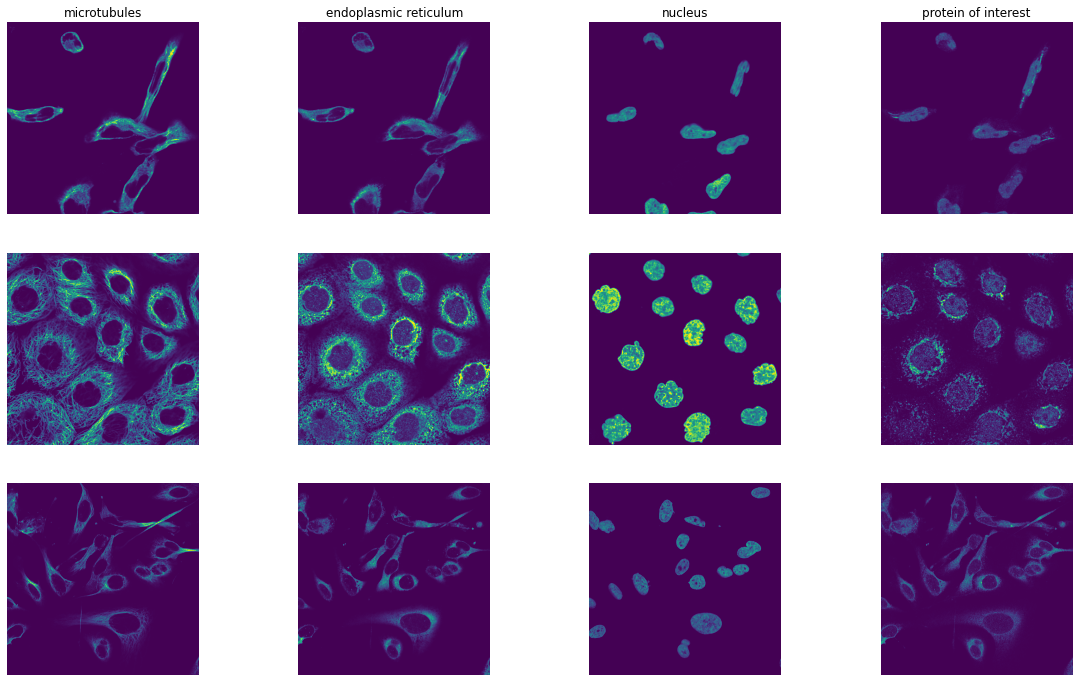

In [8]:
fig, ax = plt.subplots(3,4, figsize=(20,12))
for j in range(3):
    for i in range(4):
        img = plt.imread(images[i][j])
        if j == 0: ax[j,i].set_title(titles[i])
        ax[j,i].imshow(img)
        ax[j,i].axis('off')
plt.show()

Displaying 4 channels in a single image by blending them:

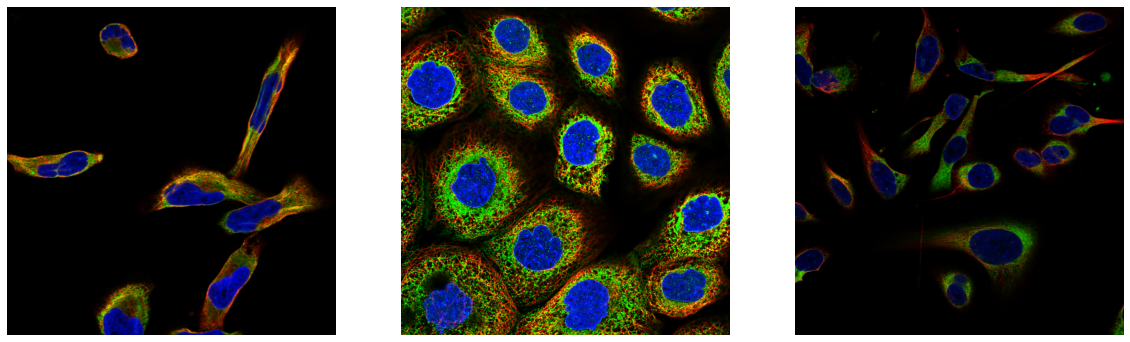

In [9]:
fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    endoplasmicrec = plt.imread(er[i])    
    nuclei = plt.imread(nu[i])
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

Visualizing an image for each class (only images representing single class):


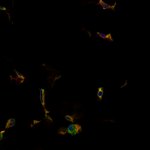
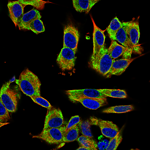
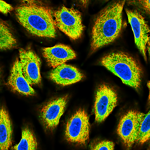
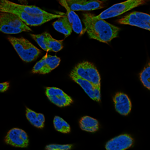
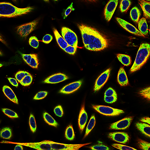
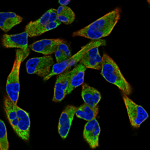
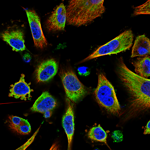
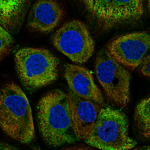
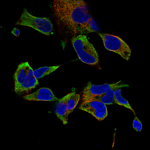
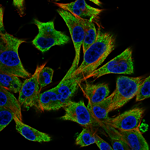
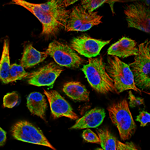
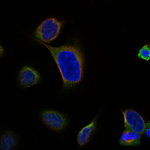
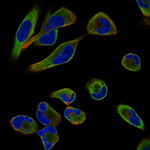
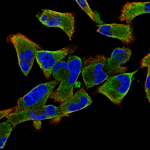
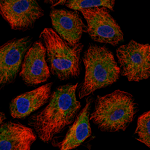
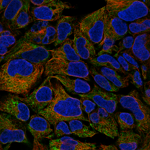
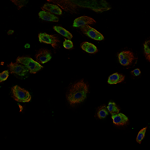
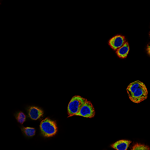
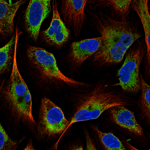


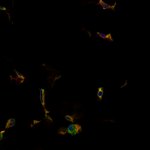
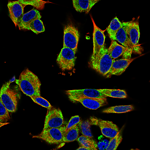
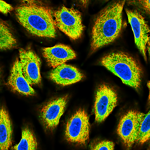
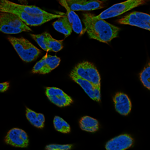
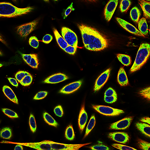
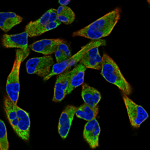
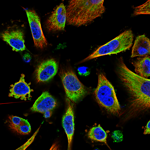
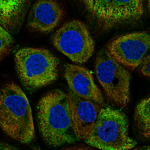
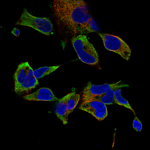
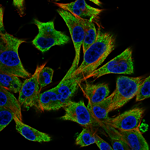
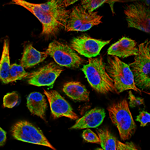
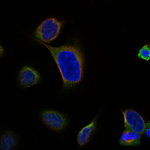
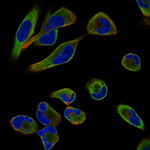
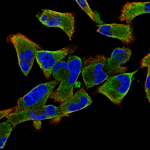
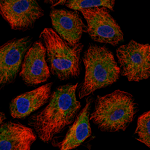
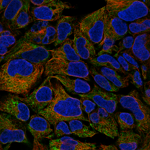
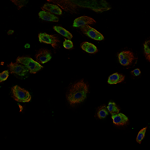
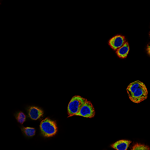
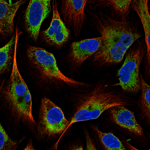

In [10]:
!pip install ipyplot -q
import imageio
import ipyplot
labels = [str(i) for i in range(19)]
class_images = []
for label in labels:
    r_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_red.png'
    y_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_yellow.png'
    b_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_blue.png'
    r = imageio.imread(path/'train'/r_img)
    y = imageio.imread(path/'train'/y_img)
    b = imageio.imread(path/'train'/b_img)
    rgb = np.dstack((r,y,b))
    class_images.append(PILImage.create(rgb))

codes = [
'0. Nucleoplasm',
'1. Nuclear membrane',
'2. Nucleoli',
'3. Nucleoli fibrillar center',
'4. Nuclear speckles',
'5. Nuclear bodies',
'6. Endoplasmic reticulum',
'7. Golgi apparatus',
'8. Intermediate filaments',
'9. Actin filaments',
'10. Microtubules',
'11. Mitotic spindle',
'12. Centrosome',
'13. Plasma membrane',
'14. Mitochondria',
'15. Aggresome',
'16. Cytosol',
'17. Vesicles and punctate cytosolic patterns',
'18. Negative'
]

ipyplot.plot_images(images=class_images, labels=codes, max_images=19, img_width=150)

In [11]:
cell_dir = '../input/hpa-mask/hpa_cell_mask' #mask files made using CellSegmentator

In [12]:
ROOT = '../input/hpa-single-cell-image-classification/'
train_or_test = 'train'


In [13]:
for x in labels: df_train[x] = df_train['Label'].apply(lambda r: int(x in r.split('|')))

Getting samples of each cell type:

In [14]:
dfs_0 = df_train[df_train['Label'] == '0'].sample(n=300, random_state=42).reset_index(drop=True)
dfs_1 = df_train[df_train['1'] == 1].sample(n=400, random_state=42).reset_index(drop=True)
dfs_1u = df_train[df_train['Label'] == '1'].sample(n=221, random_state=42).reset_index(drop=True)
dfs_2 = df_train[df_train['Label'] == '2'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_3 = df_train[df_train['Label'] == '3'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_4 = df_train[df_train['Label'] == '4'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_5 = df_train[df_train['Label'] == '5'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_6 = df_train[df_train['6'] == 1].sample(n=500, random_state=42).reset_index(drop=True)
dfs_7 = df_train[df_train['Label'] == '7'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_8 = df_train[df_train['Label'] == '8'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_9 = df_train[df_train['9'] == 1].sample(n=400, random_state=42).reset_index(drop=True)
dfs_9u = df_train[df_train['Label'] == '9'].sample(n=200, random_state=42).reset_index(drop=True)
dfs_10 = df_train[df_train['10'] == 1].sample(n=400, random_state=42).reset_index(drop=True)
dfs_10u = df_train[df_train['Label'] == '10'].sample(n=200, random_state=42).reset_index(drop=True)
dfs_11 = df_train[df_train['11'] == 1].reset_index(drop=True)
dfs_12 = df_train[df_train['Label'] == '12'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_13 = df_train[df_train['Label'] == '13'].sample(n=400, random_state=42).reset_index(drop=True)
dfs_14 = df_train[df_train['Label'] == '14'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_15 = df_train[df_train['15'] == 1].reset_index(drop=True)
dfs_16 = df_train[df_train['Label'] == '16'].sample(n=350, random_state=42).reset_index(drop=True)
dfs_17 = df_train[df_train['17'] == 1].sample(n=500, random_state=42).reset_index(drop=True)
dfs_18 = df_train[df_train['18'] == 1].reset_index(drop=True)
dfs_ = [dfs_0, dfs_1, dfs_1u, dfs_2, dfs_3, dfs_4, dfs_5, dfs_6, dfs_7, dfs_8, dfs_9, dfs_9u, dfs_10, dfs_10u,
        dfs_11, dfs_12, dfs_13, dfs_14, dfs_15, dfs_16, dfs_17, dfs_18]

In [15]:
dfs = pd.concat(dfs_, ignore_index=True)
dfs.drop_duplicates(inplace=True, ignore_index=True)
len(dfs)

7960

In [16]:
dfs1 = dfs.drop(dfs[dfs.Label.str.contains(r'[|*]')].index)

In [17]:
dfs1.Label.unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18'], dtype=object)

In [18]:
dfs.head()

,ID,Label,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6166673c-bbad-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2533bcc2-bba5-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,280f88c2-bba5-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13669cc6-bbaa-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
len(dfs1)

6478

In [20]:
unique_counts = {}
for lbl in labels:
    unique_counts[lbl] = len(dfs1[dfs1.Label == lbl])

full_counts = {}
for lbl in labels:
    count = 0
    for row_label in dfs['Label']:
        if lbl in row_label.split('|'): count += 1
    full_counts[lbl] = count
    
counts = list(zip(full_counts.keys(), full_counts.values(), unique_counts.values()))
counts = np.array(sorted(counts, key=lambda x:-x[1]))
counts = pd.DataFrame(counts, columns=['label', 'full_count', 'unique_count'])
counts.set_index('label').T

label,0,16,2,13,5,1,12,3,4,7,14,9,8,10,6,17,15,11,18
full_count,978,798,655,589,577,566,566,552,549,548,536,535,528,526,505,502,252,78,34
unique_count,300,350,500,400,500,221,500,500,500,500,500,244,500,310,308,228,82,1,34


# Creating new features

In [21]:
def get_cropped_cell(img, msk):
    bmask = msk.astype(int)[...,None]
    masked_img = img * bmask
    true_points = np.argwhere(bmask)
    top_left = true_points.min(axis=0)
    bottom_right = true_points.max(axis=0)
    cropped_arr = masked_img[top_left[0]:bottom_right[0]+1,top_left[1]:bottom_right[1]+1]
    return cropped_arr

In [22]:
def get_stats(cropped_cell):
    x = (cropped_cell/255.0).reshape(-1,3).mean(0)
    x2 = ((cropped_cell/255.0)**2).reshape(-1,3).mean(0)
    return x, x2

In [23]:
def read_img(image_id, color, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}_{color}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.max() > 255:
        img_max = img.max()
        img = (img/255).astype('uint8')
    return img

In [24]:
from tqdm import tqdm
import cv2
x_tot,x2_tot = [],[]
lbls = []
num_files = len(dfs1)
all_cells = []
cell_mask_dir = '../input/hpa-mask/hpa_cell_mask'

with zipfile.ZipFile('cells.zip', 'w') as img_out:

    for idx in tqdm(range(0,num_files,33)):
        image_id = dfs1.iloc[idx].ID
        labels = dfs1.iloc[idx].Label
        cell_mask = np.load(f'{cell_mask_dir}/{image_id}.npz')['arr_0']
        red = read_img(image_id, "red", train_or_test, None)
        green = read_img(image_id, "green", train_or_test, None)
        blue = read_img(image_id, "blue", train_or_test, None)
        stacked_image = np.transpose(np.array([blue, green, red]), (1,2,0))

        for cell in range(1, np.max(cell_mask) + 1):
            bmask = cell_mask == cell
            cropped_cell = get_cropped_cell(stacked_image, bmask)
            fname = f'{image_id}_{cell}.jpg'
            im = cv2.imencode('.jpg', cropped_cell)[1]
            img_out.writestr(fname, im)
            x, x2 = get_stats(cropped_cell)
            x_tot.append(x)
            x2_tot.append(x2)
            all_cells.append({
                'image_id': image_id,
                'r_mean': x[0],
                'g_mean': x[1],
                'b_mean': x[2],
                'cell_id': cell,
                'image_labels': labels,
                'size1': cropped_cell.shape[0],
                'size2': cropped_cell.shape[1],
            })

#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
cell_df = pd.DataFrame(all_cells)
cell_df.to_csv('cell_df.csv', index=False)
print('mean:',img_avr, ', std:', img_std)

100%|██████████| 197/197 [09:16<00:00,  2.82s/it]

mean: [0.07138233 0.04389228 0.07736673] , std: [0.16963373 0.10442992 0.14300483]


In [25]:
df = pd.read_csv('cell_df.csv')

In [26]:
df.head()

,image_id,r_mean,g_mean,b_mean,cell_id,image_labels,size1,size2
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.019785,0.007022,0.081189,1,0,510,656
1,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.021645,0.011319,0.059531,2,0,875,748
2,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.026710,0.014573,0.054268,3,0,924,760
3,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.018123,0.009205,0.065854,4,0,844,538
4,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0.029577,0.014019,0.037737,5,0,620,1168


In [27]:
df['image_labels'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       18])

In [28]:
train_test_df = df[['r_mean','g_mean','b_mean','size1','size2','image_labels']]
train_test_df.head()


,r_mean,g_mean,b_mean,size1,size2,image_labels
0,0.019785,0.007022,0.081189,510,656,0
1,0.021645,0.011319,0.059531,875,748,0
2,0.026710,0.014573,0.054268,924,760,0
3,0.018123,0.009205,0.065854,844,538,0
4,0.029577,0.014019,0.037737,620,1168,0


In [29]:
import pandas as pd
from sklearn import preprocessing

x = train_test_df.drop(["image_labels"],1).values #returns a numpy array
std_scaler = preprocessing.StandardScaler()
x_scaled = std_scaler.fit_transform(x)
temp_train_test_df = pd.DataFrame(x_scaled)

In [30]:
temp_train_test_df['image_labels'] = train_test_df['image_labels']

In [31]:
temp_train_test_df.head()

,0,1,2,3,4,image_labels
0,-1.010573,-0.762687,0.085381,0.580926,1.261101,0
1,-0.974142,-0.673789,-0.398409,2.399779,1.708996,0
2,-0.874946,-0.606481,-0.515961,2.643954,1.767418,0
3,-1.043138,-0.717529,-0.257162,2.245301,0.686626,0
4,-0.818793,-0.617939,-0.885223,1.129074,3.753737,0


In [32]:
X = temp_train_test_df.drop(["image_labels"],1).values
y = temp_train_test_df['image_labels']




from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

In [33]:
from sklearn.metrics import accuracy_score

# Supervised Learning Model 1: RandomForestClassifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
clf = RandomForestClassifier(n_estimators=50)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

### Evaluation (RandomForestClassifier)

In [36]:
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.29739507959479017


## Parameter Tuning (RandomForestClassifier)

n_estimators=100

In [37]:
clf_2 = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_2.fit(X_train,y_train)

y_pred_new=clf_2.predict(X_test)

### Evaluation (RandomForestClassifier) after Parameter Tuning

In [38]:
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred_new)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.3068017366136035


# Supervised Learning Model 2: KNeighborsClassifier

In [39]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

### Evaluation (KNeighborsClassifier)

In [47]:
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.22648335745296672


## Parameter Tuning (KNeighborsClassifier)

n_neighbors=10

In [41]:
#Create KNN Classifier
knn_new = KNeighborsClassifier(n_neighbors=10)

#Train the model using the training sets
knn_new.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_new = knn_new.predict(X_test)

### Evaluation (KNeighborsClassifier) after Parameter Tuning

In [42]:
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred_new)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.23444283646888567


# Advanced Model: XGBClassifier

In [43]:
import xgboost as xgb
from xgboost import XGBClassifier
model=xgb.XGBClassifier(random_state=1,learning_rate=0.001)
model.fit(X_train, y_train)

[20:10:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Evaluation (XGBClassifier)

In [44]:
model.score(X_test,y_test)

0.243849493487699

## Parameter Tuning (XGBClassifier)

learning_rate=0.1

In [45]:
model_new=xgb.XGBClassifier(random_state=1,learning_rate=0.1)
model_new.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:10:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Evaluation (XGBClassifier) after Parameter Tuning

In [46]:
model_new.score(X_test,y_test)

0.28798842257597684